# Why we need to generate random numbers in crypto?

Remember the one time pad:

In [90]:
from random import randrange

m = "01011101000101110101"
secret_key = ''.join([str(randrange(2)) for _ in range(len(m))])
ciphertext = ''.join([str((int(m)+int(s))%2) for m, s in zip(m, secret_key)])

In [91]:
print(f"message:\n\t{m}")
print(f"secret_key\n\t{secret_key}")
print(f"ciphertext\n\t{ciphertext}")

message:
	01011101000101110101
secret_key
	10101111001100001011
ciphertext
	11110010001001111110


If the secret_key is a sequence known by Alice and Bob and generated completely random, then the cryptosystem is perfectly secret. Problems for one time pad?

* key lenght has to be at least the same as message lenght
* the key has to be completely random 
* Alice and Bob have to meet each time to exchange the secret key

Let's design a system very close to pure random:

# Linear congruential generators

A linear congruential generator (LCG) is an algorithm that yields a sequence of pseudo-randomized numbers calculated with a discontinuous piecewise linear equation.

$$X_{n+1}=X_n*a+s \textrm{ (mod m)}$$.

There are several LCGs, in the example we take the one of numerical recipes correspoding to the values: a = 1664525, b = 1013904223 and m = $2^{32}$.

In [92]:
a = 1664525
c = 1013904223
m = 2**32

def lcg(s, a, c, m):    
    return (a*s+c)%m

In [93]:
s = 1
l = []
for _ in range(100000):
    s = lcg(s, a, c, m)
    l.append(s/2**32)

<Figure size 432x288 with 0 Axes>

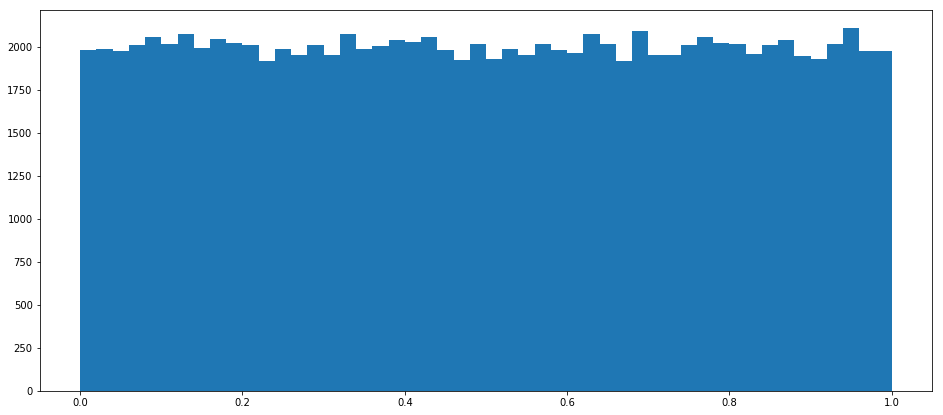

In [94]:
import matplotlib.pyplot as plt

plt.clf()
fig = plt.figure(figsize=(16,7))
plt.hist(l, bins=50)
plt.show()

The good thing about pseudorandom generators is that you can reconstruct the pseudorandom numbers taking the same initial seed

In [96]:
s = 5
for _ in range(10):
    s = lcg(s, a, c, m)
    print(s)

1022226848
3144284287
1043999698
3663386889
3076951764
1547742243
2142806822
948330573
220562760
3732498439


In [97]:
s = 5
for _ in range(10):
    s = lcg(s, a, c, m)
    print(s)

1022226848
3144284287
1043999698
3663386889
3076951764
1547742243
2142806822
948330573
220562760
3732498439


This can be useful!. Alice and Bob can generate the same randomness if they keep the seed as a secret!. The secret is the Diffie-Hellman key they generated.

# Building a cipher from the PRNG, the stream cipher

In [138]:
from random import seed

def PRNG(s: int, l: int) -> list:
    seed(s)
    psrn = []
    while len(psrn)<l:
        psrn.append(randrange(2))
    return ''.join([str(n) for n in psrn])
prng1 = PRNG(12, 20)
prng2 = PRNG(12, 20)

print(prng1)
print(prng2)
    

11101011110001101000
11101011110001101000


In [112]:
import secrets

secrets.randbits(16)

38290